Phụ lục 2: Mã nguồn bài toán Ảnh hưởng của các khoản khuyến khích đến mức độ tìm hiểu bệnh lý của bản thân.

Trong nội dung Khóa luận về Suy luận nhân quả và Double Machine Learning, bài toán Ảnh hưởng của các khoản khuyến khích đến mức độ tìm hiểu bệnh lý của bản thân là một trong hai bài toán đề ra trong nội dung. Bài toán này xem xét ảnh hưởng của việc áp dụng khuyến khích 

Đầu tiên, chúng ta import các thư viện cần thiết cho áp dụng các kỹ thuật. Bộ dữ liệu được tích hợp trong package causaldata, doubleml được sử dụng cho Double Machine Learning.

In [14]:
import numpy as np
import pandas as pd
import doubleml as dml
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import matplotlib.pyplot as plt
from causaldata import thornton_hiv
from sklearn.linear_model import LinearRegression

Chúng ta import dữ liệu bài toán từ package và mô tả dữ liệu.

In [15]:
data = thornton_hiv.load_pandas().data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4820 entries, 0 to 4819
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   villnum  4793 non-null   float64
 1   got      2894 non-null   float64
 2   distvct  4820 non-null   float32
 3   tinc     2901 non-null   float32
 4   any      2901 non-null   float64
 5   age      4379 non-null   float64
 6   hiv2004  2894 non-null   float64
dtypes: float32(2), float64(5)
memory usage: 226.1 KB


In [16]:
data.describe()

,villnum,got,distvct,tinc,any,age,hiv2004
count,4793.000000,2894.000000,4820.000000,2901.000000,2901.000000,4379.000000,2894.000000
mean,63.477571,0.696614,2.002633,0.988040,0.765943,33.651747,0.059088
std,48.311774,0.459800,1.256523,0.901361,0.423481,13.162858,0.255527
min,1.000000,0.000000,0.000000,0.000000,0.000000,11.000000,-1.000000
25%,14.000000,0.000000,1.029921,0.094560,1.000000,23.000000,0.000000
50%,57.000000,1.000000,1.674839,0.945600,1.000000,32.000000,0.000000
75%,111.000000,1.000000,2.742947,1.891200,1.000000,43.000000,0.000000
max,145.000000,1.000000,5.191559,2.836800,1.000000,84.000000,1.000000


Bộ dữ liệu có nhiều trường thông tin NaN, chúng ta sẽ loại bỏ các bản ghi chứa dữ liệu đó.

In [17]:
data = data.dropna()
data = data[(data != -1).all(axis=1)]
description = data.describe()

print(description)

           villnum          got      distvct         tinc          any  \
count  2812.000000  2812.000000  2812.000000  2812.000000  2812.000000   
mean     62.926387     0.692034     2.015685     1.006903     0.780228   
std      49.196235     0.461734     1.265411     0.898624     0.414166   
min       1.000000     0.000000     0.032887     0.000000     0.000000   
25%      12.000000     0.000000     1.034826     0.189120     1.000000   
50%      57.000000     1.000000     1.688662     0.945600     1.000000   
75%     111.000000     1.000000     2.796018     1.891200     1.000000   
max     145.000000     1.000000     5.191559     2.836800     1.000000   

               age      hiv2004  
count  2812.000000  2812.000000  
mean     33.384780     0.062589  
std      13.651709     0.242265  
min      11.000000     0.000000  
25%      22.000000     0.000000  
50%      32.000000     0.000000  
75%      43.000000     0.000000  
max      80.000000     1.000000  


Chúng ta sẽ biểu diễn tương quan của bộ dữ liệu.

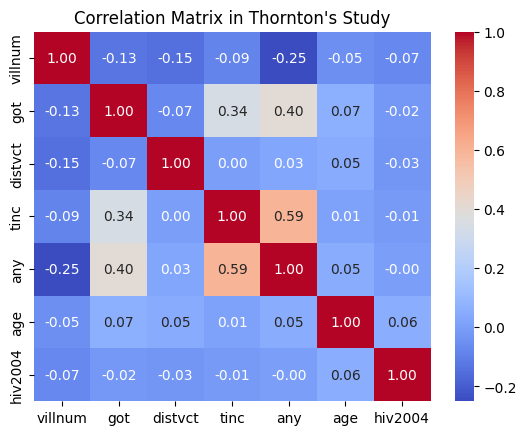

In [18]:
df_data = pd.DataFrame(data=data)
import seaborn as sns
correlation_matrix = df_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix in Thornton's Study")
plt.show()

Chúng ta sẽ thực hiện Linear Regression để đánh giá ảnh hưởng của biến any lên biến got.

In [19]:
X = df_data[['any', 'villnum', 'distvct', 'age', 'hiv2004']]
y = df_data['got']

model_sklearn = LinearRegression()
model_sklearn.fit(X, y)
print('Hệ số của biến any lên biến got:', model_sklearn.coef_[0])

Hệ số của biến any lên biến got: 0.4371303556841299


Chúng ta sẽ thực hiện DML cho bài toán này. Các mô hình có thể được sử dụng là PLR, IRM, trong đó IRM chúng ta có thể sử dụng ATE và ATTE cho ước lượng.

In [20]:
feature_base_any = ['villnum', 'hiv2004', 'distvct', 'age']
dml_data_base_any = dml.DoubleMLData(data=data,  x_cols=feature_base_any, y_col='got', d_cols='any')
print(dml_data_base_any)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: got
Treatment variable(s): ['any']
Covariates: ['villnum', 'hiv2004', 'distvct', 'age']
Instrument variable(s): None
No. Observations: 2812

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
Index: 2812 entries, 0 to 4791
Columns: 7 entries, villnum to hiv2004
dtypes: float32(2), float64(5)
memory usage: 153.8 KB



In [25]:
ml_l = RandomForestRegressor(n_estimators=100, max_features=20, max_depth=5, min_samples_leaf=2)
ml_m = RandomForestRegressor(n_estimators=100, max_features=20, max_depth=5, min_samples_leaf=2)
np.random.seed(123)
dml_plr_obj_rf = dml.DoubleMLPLR(dml_data_base_any, ml_l=ml_l, ml_m=ml_m)
print(dml_plr_obj_rf.fit())

================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: got
Treatment variable(s): ['any']
Covariates: ['villnum', 'hiv2004', 'distvct', 'age']
Instrument variable(s): None
No. Observations: 2812

------------------ Score & algorithm ------------------
Score function: partialling out
DML algorithm: dml2

------------------ Machine learner   ------------------
Learner ml_l: RandomForestRegressor(max_depth=5, max_features=20, min_samples_leaf=2)
Learner ml_m: RandomForestRegressor(max_depth=5, max_features=20, min_samples_leaf=2)
Out-of-sample Performance:
Learner ml_l RMSE: [[0.45105819]]
Learner ml_m RMSE: [[0.40099526]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1
Apply cross-fitting: True

------------------ Fit summary       ------------------
         coef   std err          t         P>|t|     2.5 %    97.5 %
any  0.420476  0.021612  19.455637  2.61087

In [23]:
ml_g = RandomForestRegressor(n_estimators=100, max_features=20, max_depth=5, min_samples_leaf=2)
ml_m = RandomForestClassifier(n_estimators=100, max_features=20, max_depth=5, min_samples_leaf=2)
np.random.seed(123)
dml_irm_obj_rf_ate = dml.DoubleMLIRM(dml_data_base_any, ml_g=ml_g, ml_m=ml_m)
print(dml_irm_obj_rf_ate.fit())

================== DoubleMLIRM Object ==================

------------------ Data summary      ------------------
Outcome variable: got
Treatment variable(s): ['any']
Covariates: ['villnum', 'hiv2004', 'distvct', 'age']
Instrument variable(s): None
No. Observations: 2812

------------------ Score & algorithm ------------------
Score function: ATE
DML algorithm: dml2

------------------ Machine learner   ------------------
Learner ml_g: RandomForestRegressor(max_depth=5, max_features=20, min_samples_leaf=2)
Learner ml_m: RandomForestClassifier(max_depth=5, max_features=20, min_samples_leaf=2)
Out-of-sample Performance:
Learner ml_g0 RMSE: [[0.4671459]]
Learner ml_g1 RMSE: [[0.40527883]]
Learner ml_m RMSE: [[0.40121232]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1
Apply cross-fitting: True

------------------ Fit summary       ------------------
        coef  std err          t         P>|t|     2.5 %    97.5 %
any  0.42108   0.0258

In [24]:
ml_g = RandomForestRegressor(n_estimators=100, max_features=20, max_depth=5, min_samples_leaf=2)
ml_m = RandomForestClassifier(n_estimators=100, max_features=20, max_depth=5, min_samples_leaf=2)
np.random.seed(123)
dml_irm_obj_rf_atte = dml.DoubleMLIRM(dml_data_base_any, ml_g=ml_g, ml_m=ml_m, score='ATTE')
print(dml_irm_obj_rf_atte.fit())

================== DoubleMLIRM Object ==================

------------------ Data summary      ------------------
Outcome variable: got
Treatment variable(s): ['any']
Covariates: ['villnum', 'hiv2004', 'distvct', 'age']
Instrument variable(s): None
No. Observations: 2812

------------------ Score & algorithm ------------------
Score function: ATTE
DML algorithm: dml2

------------------ Machine learner   ------------------
Learner ml_g: RandomForestRegressor(max_depth=5, max_features=20, min_samples_leaf=2)
Learner ml_m: RandomForestClassifier(max_depth=5, max_features=20, min_samples_leaf=2)
Out-of-sample Performance:
Learner ml_g0 RMSE: [[0.4671459]]
Learner ml_g1 RMSE: [[0.40527883]]
Learner ml_m RMSE: [[0.40121232]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1
Apply cross-fitting: True

------------------ Fit summary       ------------------
         coef   std err          t         P>|t|     2.5 %    97.5 %
any  0.419783  0.0

Để ước lượng ảnh hưởng của giá trị khoản khuyến khích tới hành vi Tìm hiểu bệnh lý, chúng ta sẽ ước lượng ảnh hưởng của biến tinc lên biến got.

In [27]:
X = df_data[['tinc', 'villnum', 'distvct', 'age', 'hiv2004', 'any']]
y = df_data['got']

model_sklearn_tinc = LinearRegression()
model_sklearn_tinc.fit(X, y)
print('Hệ số của biến atinc lên biến got:', model_sklearn_tinc.coef_[0])

Hệ số của biến atinc lên biến got: 0.08538236971602975


In [28]:
feature_base_tinc_with_any = ['any', 'villnum', 'hiv2004', 'distvct', 'age']
dml_data_base_tinc_with_any = dml.DoubleMLData(data=data,  x_cols=feature_base_tinc_with_any, y_col='got', d_cols='tinc')
print(dml_data_base_tinc_with_any)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: got
Treatment variable(s): ['tinc']
Covariates: ['any', 'villnum', 'hiv2004', 'distvct', 'age']
Instrument variable(s): None
No. Observations: 2812

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
Index: 2812 entries, 0 to 4791
Columns: 7 entries, villnum to hiv2004
dtypes: float32(2), float64(5)
memory usage: 153.8 KB



In [29]:
ml_l = RandomForestRegressor(n_estimators=100, max_features=20, max_depth=5, min_samples_leaf=2)
ml_m = RandomForestRegressor(n_estimators=100, max_features=20, max_depth=5, min_samples_leaf=2)
np.random.seed(123)
dml_plr_obj_tinc_with_any_rf = dml.DoubleMLPLR(dml_data_base_tinc_with_any, ml_l=ml_l, ml_m=ml_m)
print(dml_plr_obj_tinc_with_any_rf.fit())

================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: got
Treatment variable(s): ['tinc']
Covariates: ['any', 'villnum', 'hiv2004', 'distvct', 'age']
Instrument variable(s): None
No. Observations: 2812

------------------ Score & algorithm ------------------
Score function: partialling out
DML algorithm: dml2

------------------ Machine learner   ------------------
Learner ml_l: RandomForestRegressor(max_depth=5, max_features=20, min_samples_leaf=2)
Learner ml_m: RandomForestRegressor(max_depth=5, max_features=20, min_samples_leaf=2)
Out-of-sample Performance:
Learner ml_l RMSE: [[0.41888418]]
Learner ml_m RMSE: [[0.72119755]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1
Apply cross-fitting: True

------------------ Fit summary       ------------------
          coef  std err        t         P>|t|     2.5 %    97.5 %
tinc  0.088225  0.01047  8.42626  3.5

In [30]:
feature_base_tinc_without_any = ['villnum', 'hiv2004', 'distvct', 'age']
dml_data_base_tinc_without_any = dml.DoubleMLData(data=data,  x_cols=feature_base_tinc_without_any, y_col='got', d_cols='tinc')
print(dml_data_base_tinc_without_any)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: got
Treatment variable(s): ['tinc']
Covariates: ['villnum', 'hiv2004', 'distvct', 'age']
Instrument variable(s): None
No. Observations: 2812

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
Index: 2812 entries, 0 to 4791
Columns: 7 entries, villnum to hiv2004
dtypes: float32(2), float64(5)
memory usage: 153.8 KB



In [31]:
ml_l = RandomForestRegressor(n_estimators=100, max_features=20, max_depth=5, min_samples_leaf=2)
ml_m = RandomForestRegressor(n_estimators=100, max_features=20, max_depth=5, min_samples_leaf=2)
np.random.seed(123)
dml_plr_obj_tinc_without_any_rf = dml.DoubleMLPLR(dml_data_base_tinc_without_any, ml_l=ml_l, ml_m=ml_m)
print(dml_plr_obj_tinc_without_any_rf.fit())

================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: got
Treatment variable(s): ['tinc']
Covariates: ['villnum', 'hiv2004', 'distvct', 'age']
Instrument variable(s): None
No. Observations: 2812

------------------ Score & algorithm ------------------
Score function: partialling out
DML algorithm: dml2

------------------ Machine learner   ------------------
Learner ml_l: RandomForestRegressor(max_depth=5, max_features=20, min_samples_leaf=2)
Learner ml_m: RandomForestRegressor(max_depth=5, max_features=20, min_samples_leaf=2)
Out-of-sample Performance:
Learner ml_l RMSE: [[0.45105819]]
Learner ml_m RMSE: [[0.90104886]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1
Apply cross-fitting: True

------------------ Fit summary       ------------------
         coef  std err          t         P>|t|     2.5 %    97.5 %
tinc  0.16904  0.00882  19.166257  7.082546